In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import os
import sys
import tqdm as notebook_tqdm
import pandas as pd
import datetime
import time
import PIL

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

/home/christian.foley/.conda/envs/pt_tf_cross/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print("System path: "+module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import micro_dl.torch_unet.networks.Unet2D as Unet2D
import micro_dl.torch_unet.networks.Unet25D as Unet25D
import micro_dl.torch_unet.networks.layers.ConvBlock2D as ConvBlock2D
import micro_dl.torch_unet.networks.layers.ConvBlock3D as ConvBlock3D
import micro_dl.torch_unet.utils.dataset as ds
import micro_dl.torch_unet.utils.io as io
import micro_dl.torch_unet.utils.training as training 

System path: /home/christian.foley/virtual_staining/microDL


Using TensorFlow backend.


### Get data
I will use the TorchDataset object to convert the dataset created by microDL's tensorflow 1.x dataset creation object into a format usable by the pytorch unet

In [6]:
config_file_path = '../micro_dl/config_train_25D.yml'

In [7]:
torch_data_container = ds.TorchDataset(config_file_path, 
                                       transforms = [ds.ToTensor()],
                                      target_transforms = [ds.ToTensor()])
print(len(torch_data_container))

train_dataset = torch_data_container['train']
test_dataset = torch_data_container['test']
val_dataset = torch_data_container['val']
print(len(train_dataset), len(test_dataset), len(val_dataset))

3
173 20 25


### Visualise Data
We can plot out the data to view the 5 z slice phase images next to the target that the network needs to translate them into. This is an important step to verify that we are feeding the correct data in the correct orders into the network.

In [8]:
rows = 3

samp = train_dataset[0][0].cpu().numpy()[:rows]
targ = train_dataset[0][1].cpu().numpy()

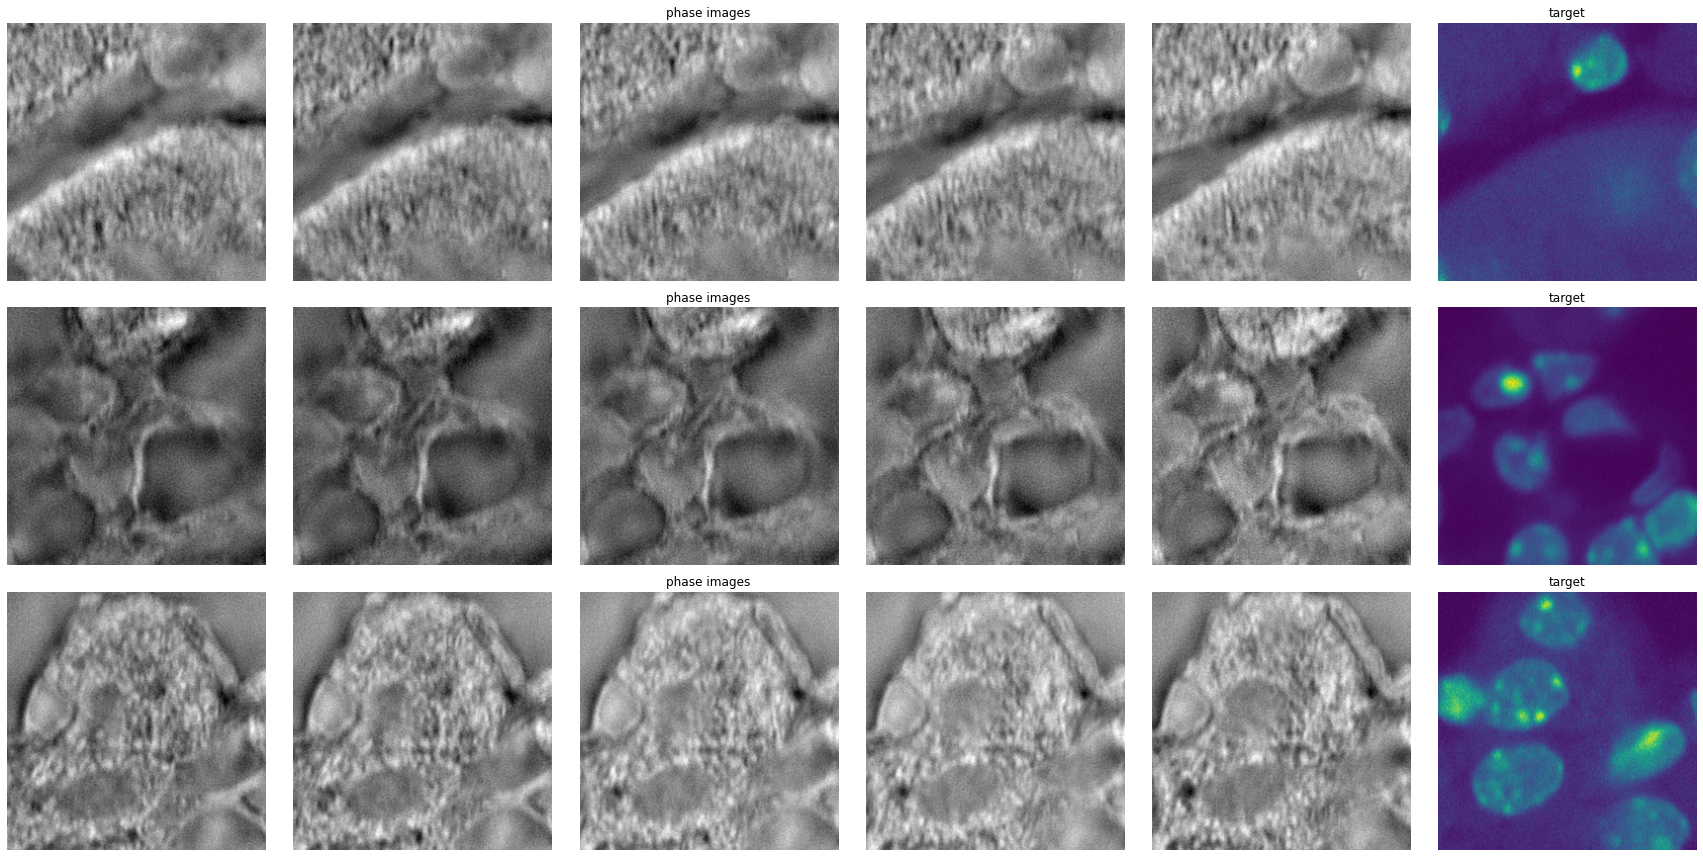

In [9]:
%matplotlib inline
fig, ax = plt.subplots(samp.shape[0],6, figsize = (24,4*samp.shape[0]))

for i in range(samp.shape[0]):
    for j in range(5):
        ax[i][j].imshow(samp[i][0][j], cmap = 'gray')
        if j == 2:
            ax[i][j].set_title('phase images')
        ax[i][j].axis('off')
    ax[i][5].imshow(targ[i][0][0])
    ax[i][5].set_title('target')
    ax[i][5].axis('off')
    
plt.tight_layout()
plt.show()

Looks like what we expected. Now we can pass this into our network to try training.

### Training

To train the network we will: <br>
**1.)** Create dataloaders to feed our datasets into the network<br>
**2.)** Define our model and optimization parameters; optimizer, learning rate, loss criterion, etc<br>
**3.)** Define testing protocol <br>
**4.)** Set up save directories for our model and the test results<br>
**5.)** Define and run our training loop<br>

In [10]:
# 1.) DATALOADING

batch_size = 1 # note that the tensorflow dataset already created batched samples. 
               # This means there will be an extra dimension, even with batch_size = 1. 
               # We will remove that dimension on each sample as it enters the network

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=True)

In [11]:
# verify our dataloader is working
for sample in train_dataloader:
    sample = sample[0] #remove extra 'batch' dimension
    print(sample[0].shape)
    break

torch.Size([16, 1, 5, 256, 256])


Looks good. Our inputs are in minibatches of **16**, with **1** feature channel, **5** z slice channels, each of which contains a **256x256** image

In [19]:
#2.) MODEL/OPT DEFINITION

#hyperparameters
params = {
    'model': {
        'in_channels': 1,
        'out_channels': 1,
        'residual': True,
        'task': 'reg', #regression
        'device': torch.device('cuda')
    },
    'training': {
        'epochs': 100,
        'learning_rate': 0.0003,
        'optimizer': 'adam',
        'loss': nn.MSELoss,
        'optimizer': optim.Adam,
        'testing_stride': 1
    }
}

In [20]:
#define model
model = Unet25D.Unet25d(in_channels = params['model']['in_channels'], out_channels = params['model']['out_channels'], 
                        residual = params['model']['residual'], task = params['model']['task'])
model.cuda()

Unet25d(
  (down_samp_0): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_1): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_2): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_3): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_conv_block_0): ConvBlock3D(
    (batch_norm_0): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv3d_0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (Conv3d_1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (Conv3d_2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (resid_conv): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (relu

You may notice that our model layers dont appear to be in order. Don't worry; the order they are listed in is *not* the order they are called in in the forward call. If you want to see more, you can find the model under **'micro_dl/torch_unet/networks/Unet25D.py'**.

In [21]:
#define loss criterion and optimizer
criterion = params['training']['loss']()
optimizer = params['training']['optimizer'](model.parameters(), lr = params['training']['learning_rate'])

In [22]:
print(criterion, optimizer)

MSELoss() Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)


Looks good. Now we define our testing protocols. We will use methods defined in **'micro_dl/torch_unet/utils/training.py'**.

In [23]:
#3.) TESTING CYCLE

testing_cycle = training.run_test
testing_cycle

<function micro_dl.torch_unet.utils.training.run_test(test_dataloader, model, criterion, *, plot=True, epoch=None, save_folder=None, writer=None, device=device(type='cuda'))>

Note that the testing function assumes our device to be gpu, as does our dataset converter, so thats good.

In [24]:
#4.) SAVE DIRECTORY

now = str(datetime.datetime.now()).replace(' ', '_').replace(':','_').replace('-','_')[:-10]
save_folder = f'/hpc/projects/CompMicro/projects/virtualstaining/torch_microDL_models/Unet25d/training_model_{now}'
save_folder

#we will also define the tensorboard writer here, so it can log the entire training process
writer = SummaryWriter(log_dir = save_folder)

In [ ]:
# Load image
im_path = os.path.join(INPUT_DIR, 'img_405_t000_p003_z010.tif')
im = im_utils.read_image(im_path)
# Clip top and bottom 1% of histogram for better visualization
im = norm_utils.hist_clipping(im, 1, 99)

mask_otsu = mask_utils.create_otsu_mask(im)
mask_rosin = mask_utils.create_unimodal_mask(im)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Fluorescence',fontsize=20)
ax[1].imshow(mask_otsu, cmap='gray')
ax[1].set_title('Otsu thresholding',fontsize=20)
ax[2].imshow(mask_rosin, cmap='gray')
ax[2].set_title('unimodal thresholding',fontsize=20)
for a in ax: a.axis('off')

plt.show()
plt.close('all')

Epoch 0:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


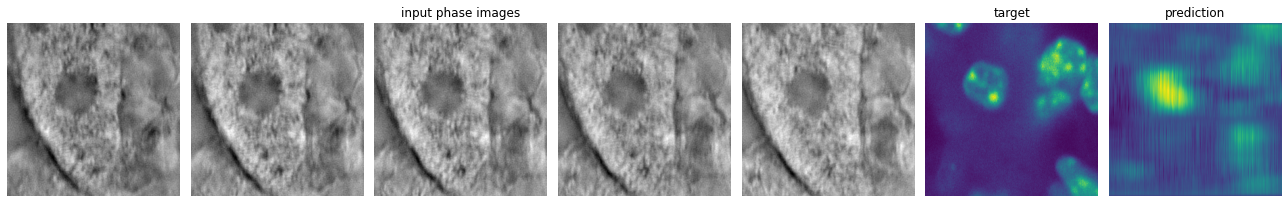

	 Training loss: 0.8907107355966734
Testing loss: 0.037833591252565385
 
Epoch 1:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


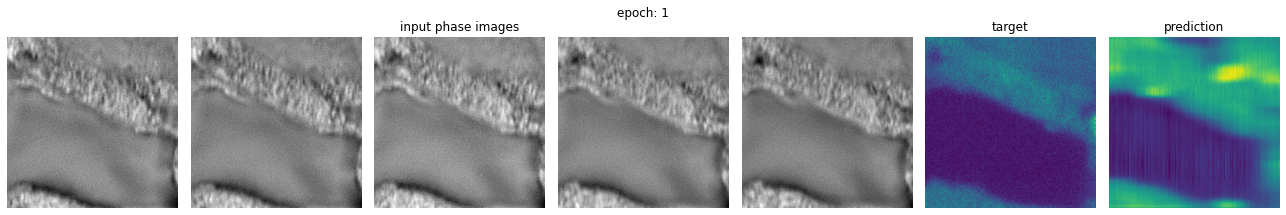

	 Training loss: 0.62660987942205
Testing loss: 0.05516179978847504
 
Epoch 2:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


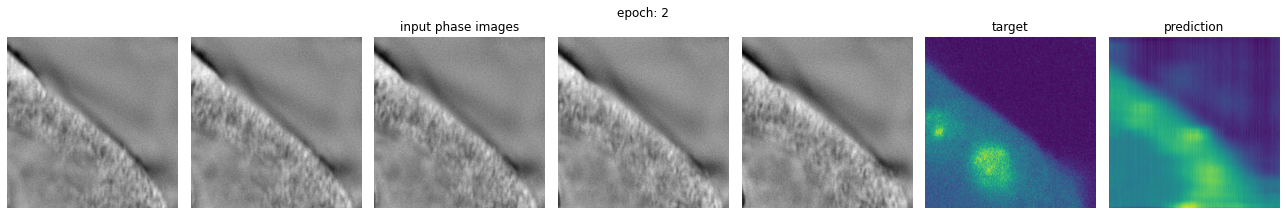

	 Training loss: 0.536110739487444
Testing loss: 0.025550119802355765
 
Epoch 3:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


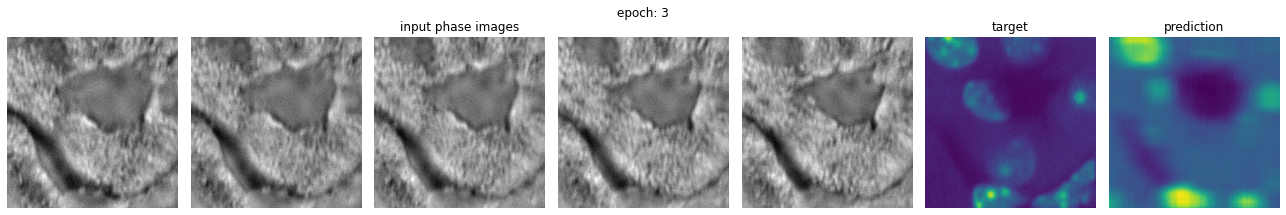

	 Training loss: 0.47908901961552613
Testing loss: 0.026775398328900336
 
Epoch 4:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


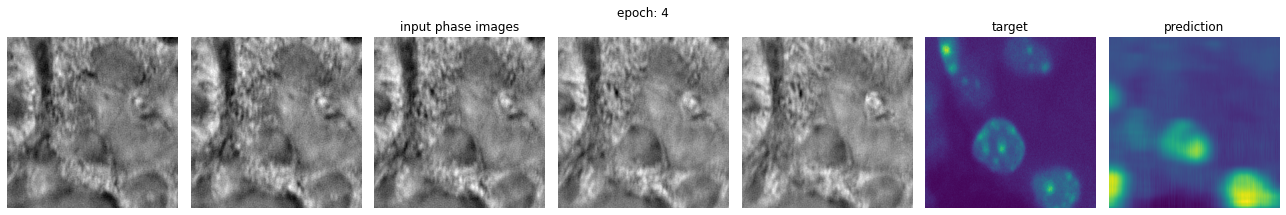

	 Training loss: 0.43391871021662143
Testing loss: 0.024087032228708265
 
Epoch 5:


In [ ]:
#5) TRAINING LOOP
start = time.time()
train_loss_list = []
test_loss_list = []
model.train()

for i in range(params['training']['epochs']):
    print(f'Epoch {i}:')
    train_loss = 0
    for current, minibatch in enumerate(train_dataloader): 
        #pretty printing
        training.show_progress_bar(train_dataloader, current)
        
        #get sample and target (remember we remove the extra batch dimension)
        sample = minibatch[0][0].to(params['model']['device']).float()
        target = minibatch[1][0].to(params['model']['device']).float()
        
        #run through model
        output = model(sample)
        loss = criterion(output, target)
        train_loss += loss.item()
        
        #optimize on weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(train_loss/train_dataset.__len__())
    
    
    #run testing cycle every 'stride' epochs
    if i % 1 == 0:
        model.eval()
        test_loss = testing_cycle(test_dataloader, model, criterion, 
                                  epoch = i, 
                                  save_folder = save_folder,
                                  writer = writer)
        model.train()
        test_loss_list.append(test_loss/test_dataset.__len__())
        
    print(f'\t Training loss: {train_loss_list[-1]}')
    if i % 1 == 0:
        print(f'\t Testing loss: {test_loss_list[-1]}')
    print(' ')
    
print(f'\t Training complete. Time taken: {time.time()-start}')
plt.figure(figsize = (14,7))
plt.plot(train_loss_list, label = 'training loss')
plt.plot(test_loss_list, label = 'testing loss')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

writer.close()

### Evaluation
We can evaluate the training accuacy from the plots. Note that the testing loss should be lower, since the model is in eval during testing, meaning that it doesn't have training augmentations (dropout, etc)
active.

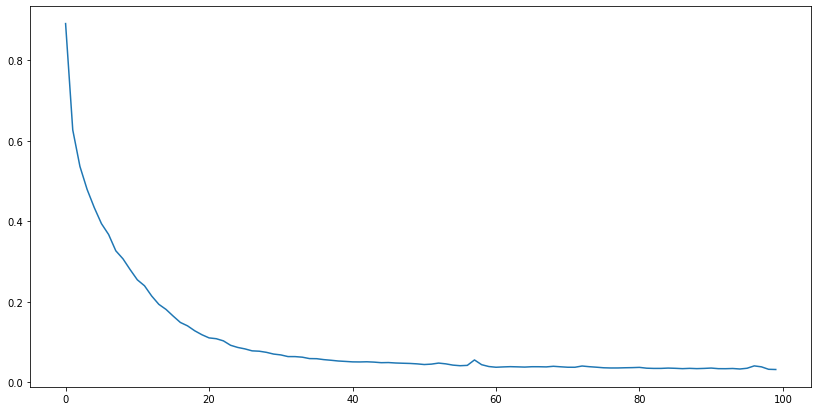

In [75]:
plt.figure(figsize = (14,7))
plt.plot(train_loss_list)

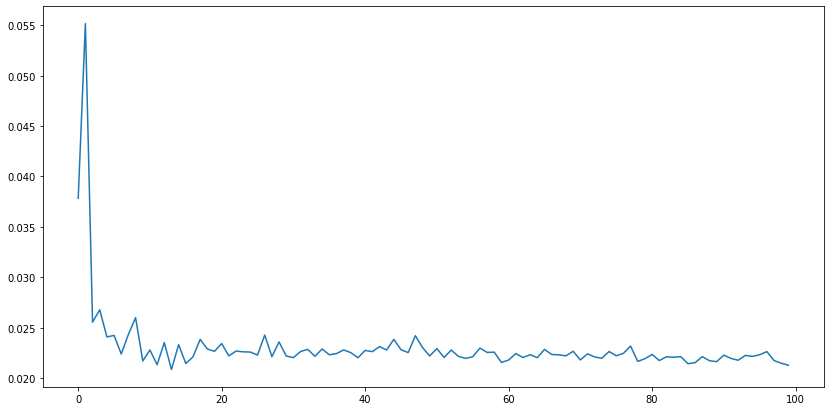

In [73]:
plt.figure(figsize = (14,7))
plt.plot(test_loss_list)

We can also use the validation set to take a look at some outputs:

	 testing 25/25 [==================================================>] (100%)


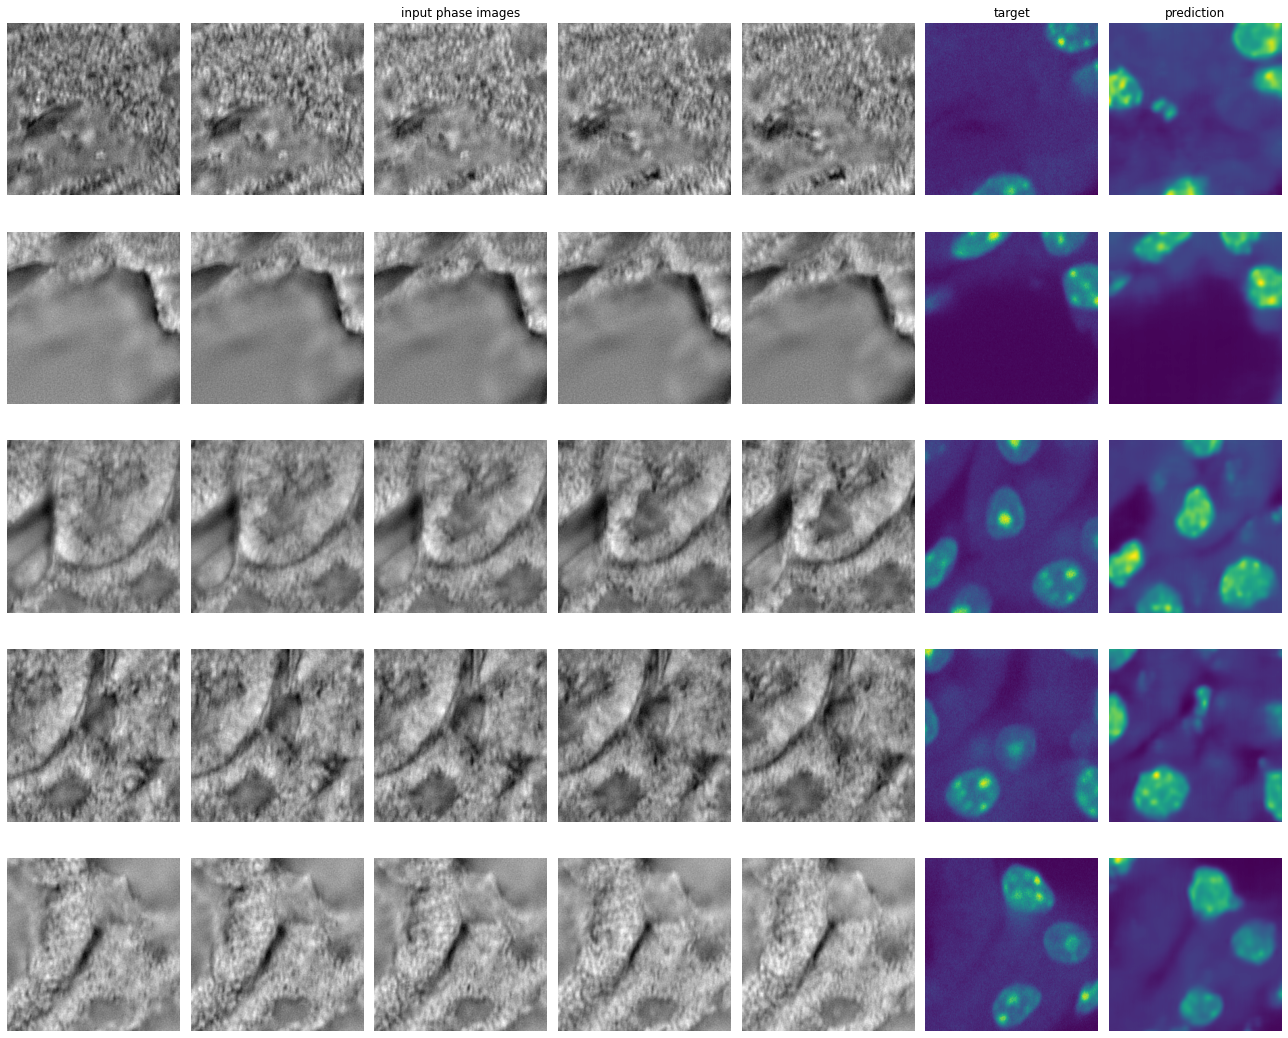

0.37188091516494753

In [61]:
testing_cycle(val_dataloader, model, criterion, plot = True, plot_num = 5)

### Comments
It appears that the model seems to be learning correctly, and from the loss charts it isn't overfitting either. What does appear to be slightly concerning is the spatial accuracy of the nuclei prediction, as well as the 'hit-rate' for the nuclei labels. As shown in some of the examples above, the prediction labels nuclei that aren't represented in the fluorescence images. I'm not sure (for this dataset specifically) if that is a representation of how well the model is performing, or (conversely), how well the fluorescent reporters are showing the nuclei. It could be that the model picks up nuclei that didn't fluoresce... or it's hallucinating.  <br>
<br>
This data needs to be compared directly to current microDL model predictions using the older tensorflow implementation.